In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [41]:
from utils.io import preprocess_data
import numpy as np
from paths import TRAINING_DATA_PATH
import glob
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

PATHS = glob.glob(TRAINING_DATA_PATH + "/*")

all_data = []
all_oxy = []
all_ds_idx = []
datasets = []

for ds_idx, path in enumerate(PATHS):
    base_filename = path.split("/")[-1].split("\\")[-1]
    datasets.append(base_filename)
    spectra, oxy = preprocess_data(f"{path}/{base_filename}_train.npz", 41)
    all_data.append(spectra)
    all_oxy.append(oxy)
    all_ds_idx.append(np.ones_like(oxy) * ds_idx)

all_data = np.hstack(all_data)
all_oxy = np.hstack(all_oxy)
all_ds_idx = np.hstack(all_ds_idx)

In [56]:
NUM_RANDOM_DATAPOINTS = 200000
random_idx = np.random.choice(len(all_data.T), NUM_RANDOM_DATAPOINTS, replace=False)

In [57]:
n_datasets = len(np.unique(all_ds_idx))
reducer = umap.UMAP()
print("embedding data")
embedding = reducer.fit_transform(all_data[:, random_idx].T)
embedding.shape

embedding data


(200000, 2)

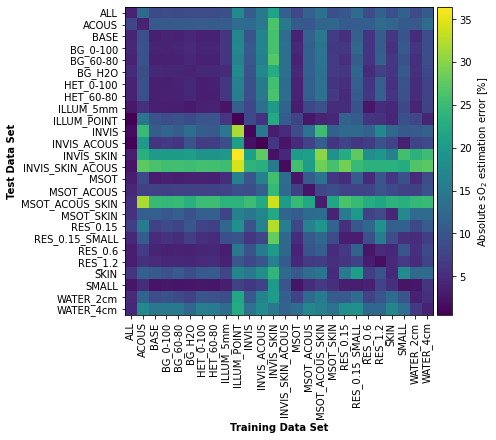

In [205]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils.constants import ALL_MODELS
from paths import TEST_DATA_PATH
import matplotlib.pyplot as plt
import numpy as np
import json

with open(f"{TEST_DATA_PATH}/result_matrix.json", "r+") as json_file:
    result_matrix_dict = json.load(json_file)

indices = np.arange(len(ALL_MODELS)).astype(int)

all_results_heatmap = np.zeros((len(ALL_MODELS), len(ALL_MODELS)))
all_results_heatmap_norm_train = np.zeros((len(ALL_MODELS), len(ALL_MODELS)))
all_results_heatmap_norm_test = np.zeros((len(ALL_MODELS), len(ALL_MODELS)))

node_sizes = []

for training_idx, model in enumerate(ALL_MODELS):
    for testing_idx, dataset in enumerate(ALL_MODELS):
        all_results_heatmap[training_idx, testing_idx] = result_matrix_dict[model][dataset]

all_results_heatmap = all_results_heatmap.T
all_results_heatmap = all_results_heatmap[indices, :][:, indices]
all_results_heatmap = all_results_heatmap.reshape((len(indices), len(indices)))

f, (ax0) = plt.subplots(1, 1, figsize=(7, 6), layout="constrained")
im = ax0.imshow(all_results_heatmap * 100)
ax0.set_yticks(np.arange(len(indices)), np.asarray(ALL_MODELS)[indices])
ax0.set_xticks(np.arange(len(indices)), np.asarray(ALL_MODELS)[indices], rotation=90)
ax0.set_xlabel("Training Data Set", fontweight="bold")
ax0.set_ylabel("Test Data Set", fontweight="bold")
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label("Absolute sO$_2$ estimation error [%]")

plt.savefig(f"all_training_testcases_{title}.png")
plt.show()

In [246]:
import glob
import numpy as np
from scipy.stats import iqr
import matplotlib.pyplot as plt
from paths import TEST_DATA_PATH

test_data_path = TEST_DATA_PATH + "/baseline/"

ground_truth = np.squeeze(np.load(test_data_path + "baseline.npz")["oxygenations"])

wls = []
results = []
est_oxy = []

for filename in glob.glob(test_data_path + "*_est_BASE*"):
    print(filename)
    num_wl = int(filename.split("_")[-1].split(".")[0])
    data = np.squeeze(np.load(filename)["estimate"])
    wls.append(num_wl)
    results.append(np.abs(data-ground_truth) * 100)
    est_oxy.append(data)

wls = np.asarray(wls)
sort_idx = np.argsort(wls)
wls = np.delete(wls[sort_idx], [4])
results = np.asarray(results)[sort_idx]
est_oxy = np.asarray(est_oxy)[sort_idx]
median_results = np.delete(np.median(results, axis=1), [4])
perc025 = np.delete(np.percentile(results, 25, axis=1), [4])
perc075 = np.delete(np.percentile(results, 75, axis=1), [4])

print(wls)
print(median_results)

H:\learned spectral unmixing\test_final_mp//baseline\baseline_est_BASE_10.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_est_BASE_15.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_est_BASE_2.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_est_BASE_20.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_est_BASE_25.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_est_BASE_3.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_est_BASE_30.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_est_BASE_35.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_est_BASE_40.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_est_BASE_41.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_est_BASE_5.npz
[ 2  3  5 10 20 25 30 35 40 41]
[19.4763318  13.14550983 12.38736029  8.65613932  7.46596428  7.42988534
  6.96705548  7.09852935  6.83058238  6.

In [248]:
import glob
import numpy as np
from scipy.stats import iqr
import matplotlib.pyplot as plt
from paths import TEST_DATA_PATH

test_data_path = TEST_DATA_PATH + "/baseline/"

dist_ground_truth = np.squeeze(np.load(test_data_path + "baseline.npz")["oxygenations"])

dist_wls = []
dist_results = []
dist_results_corr = []
dist_est_oxy = []
dist_est_oxy_corr = []

for filename in glob.glob(test_data_path + "*_dist_BASE*"):
    print(filename)
    num_wl = int(filename.split("_")[-1].split(".")[0])
    dist_data = np.squeeze(np.load(filename)["estimate"])
    dist_wls.append(num_wl)
    dist_results.append(np.abs(dist_data-dist_ground_truth) * 100)
    dist_est_oxy.append(dist_data)

dist_wls = np.asarray(dist_wls)
dist_sort_idx = np.argsort(dist_wls)
dist_wls = dist_wls[dist_sort_idx]
dist_results = np.asarray(dist_results)[dist_sort_idx]
dist_est_oxy = np.asarray(dist_est_oxy)[dist_sort_idx]
dist_median_results = np.median(dist_results, axis=1)
dist_iqr_results = iqr(dist_results, axis=1)

dist_random_points = np.random.choice(len(dist_ground_truth), 10000, replace=False)

H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_10.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_15.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_18.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_19.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_20.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_21.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_23.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_25.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_3.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_30.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_40.npz
H:\learned spectral unmixing\test_final_mp//baseline\baseline_dist_BASE_41.npz
H:\learned spectral unmixing\test_final_mp//baseline\

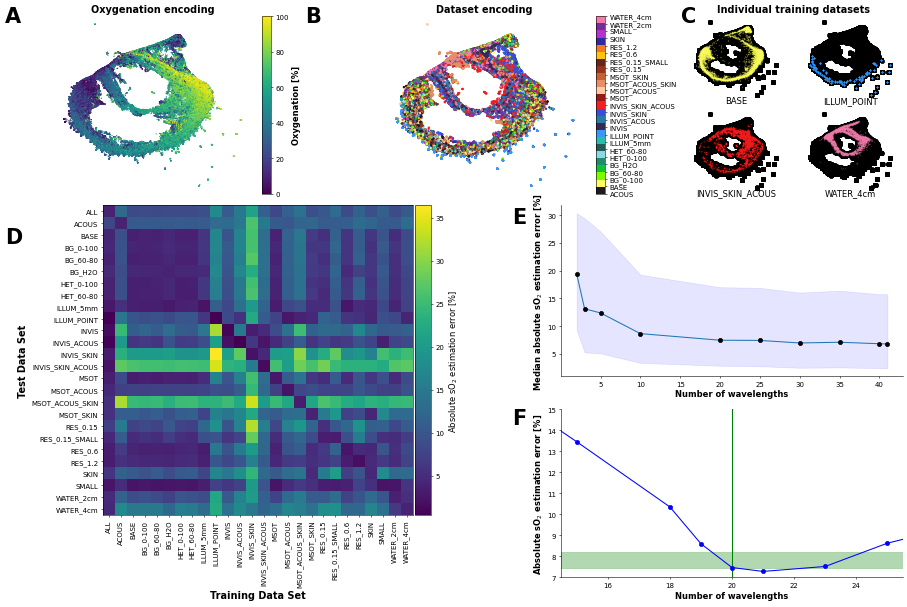

In [263]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18, 12), layout="constrained", dpi=50)
# plt.suptitle('UMAP projection of all datasets with semantic encoding', fontsize=14, fontweight="bold")

GridSpec = gridspec.GridSpec(ncols=12, nrows=3, figure=fig)

# colors = [COLOURS[int(i)] for i in all_ds_idx[random_idx]]
cmap = LinearSegmentedColormap.from_list("test", COLOURS[:25], N=n_datasets)

subfigure_2= fig.add_subfigure(GridSpec[0,0:4])
subfigure_2.text(0, 0.90, "A", size=30, weight='bold')
subplots_2= subfigure_2.subplots(1, 1)
subplots_2.set_title("Oxygenation encoding", fontweight="bold", fontsize=14)
dat_2 = subplots_2.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=all_oxy[random_idx] * 100,
    s=0.5,
    alpha=1,
    vmin=0, vmax=100)
cbar2 = plt.colorbar(dat_2)
cbar2.set_label("Oxygenation [%]", fontweight="bold", fontsize=12)
# subplots_2.set_ylim(-7, 15)
# subplots_2.set_xlim(-11, 16)
subplots_2.axis("off")
subplots_2.set_aspect('equal')


subfigure_1= fig.add_subfigure(GridSpec[0,4:9])
subfigure_1.text(0, 0.90, "B", size=30, weight='bold')
subplots_1= subfigure_1.subplots(1, 1)
subplots_1.set_title("Dataset encoding", fontweight="bold", fontsize=14)
dat = subplots_1.scatter(
    embedding[:, 0][:50000],
    embedding[:, 1][:50000],
    c=all_ds_idx[random_idx][:50000],
    s=5,
    alpha=1,
    cmap=cmap)
cbar1 = plt.colorbar(dat)
cbar1.set_ticks(np.linspace(0, n_datasets-1, 25))
cbar1.set_ticklabels(datasets)
# subplots_1.set_ylim(-7, 15)
# subplots_1.set_xlim(-11, 16)
subplots_1.axis("off")
subplots_1.set_aspect('equal')

subfigure_1= fig.add_subfigure(GridSpec[0,9:12])
((ax0, ax1), (ax2, ax3)) = subfigure_1.subplots(2, 2)
subfigure_1.suptitle("Individual training datasets", fontweight="bold", fontsize=14)
subfigure_1.text(0, 0.90, "C", size=30, weight='bold')

def plot_for_index(axis, index):  

    axis.axis("off")
    axis.set_title(datasets[index], y=-0.1)
    axis.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c="black",
        alpha=1)
    axis.scatter(
        embedding[all_ds_idx[random_idx]==index, 0],
        embedding[all_ds_idx[random_idx]==index, 1],
        c=COLOURS[index],
        alpha=0.2,
        s=1)
    axis.set_aspect('equal')

plot_for_index(ax0, 1)
plot_for_index(ax1, 8)
plot_for_index(ax2, 12)
plot_for_index(ax3, 24)

subfigure_3 = fig.add_subfigure(GridSpec[1:3,0:7])
subfigure_3.text(0, 0.90, "D", size=30, weight='bold')

ax0 = subfigure_3.subplots(1, 1)
im = ax0.imshow(all_results_heatmap * 100)
ax0.set_yticks(np.arange(len(indices)), np.asarray(ALL_MODELS)[indices])
ax0.set_xticks(np.arange(len(indices)), np.asarray(ALL_MODELS)[indices], rotation=90)
ax0.set_xlabel("Training Data Set", fontweight="bold", fontsize=14)
ax0.set_ylabel("Test Data Set", fontweight="bold", fontsize=14)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label("Absolute sO$_2$ estimation error [%]", fontsize=12)

subfigure_4 = fig.add_subfigure(GridSpec[1:2,7:])
subfigure_4.text(-0.05, 0.90, "E", size=30, weight='bold')
ax0 = subfigure_4.subplots(1, 1)
ax0.errorbar(wls, median_results)
ax0.plot(wls, median_results, "o", c="black", zorder=5)
ax0.spines.right.set_visible(False)
ax0.spines.top.set_visible(False)
ax0.fill_between(wls, perc025, perc075, color="blue", alpha=0.1)
ax0.set_ylabel("Median absolute sO$_2$ estimation error [%]", fontweight="bold", fontsize=12)
ax0.set_xlabel("Number of wavelengths", fontweight="bold", fontsize=12)


subfigure_5 = fig.add_subfigure(GridSpec[2:3,7:])
subfigure_5.text(-0.05, 0.90, "F", size=30, weight='bold')
ax0 = subfigure_5.subplots(1, 1)

ax0.plot(dist_wls, dist_median_results, c="blue")
ax0.plot(dist_wls, dist_median_results, "o", c="blue", zorder=5)
ax0.spines.right.set_visible(False)
ax0.spines.top.set_visible(False)
ax0.vlines(20, 5, 30, color="green")
ax0.fill_betweenx([dist_median_results[6], dist_median_results[6]+0.75], 2, 41, color="green", alpha=0.3)
ax0.set_ylabel("Absolute sO$_2$ estimation error [%]", fontweight="bold", fontsize=12)
ax0.set_xlabel("Number of wavelengths", fontweight="bold", fontsize=12)
ax0.set_ylim(7, 15)
ax0.set_xlim(14.5, 25.5)

plt.savefig("umap_projection.png", dpi=600)
plt.show()
plt.close()

In [59]:
len(np.unique(all_ds_idx))

25

In [60]:
COLOURS = ["#201923",
"#fcff5d",
"#7dfc00",
"#0ec434",
"#228c68",
"#8ad8e8",
"#235b54",
"#29bdab",
"#3998f5",
"#37294f",
"#277da7",
"#3750db",
"#f22020",
"#991919",
"#ffcba5",
"#e68f66",
"#c56133",
"#96341c",
"#632819",
"#ffc413",
"#f47a22",
"#2f2aa0",
"#b732cc",
"#772b9d",
"#f07cab",
"#d30b94",
"#edeff3",
"#c3a5b4",
"#946aa2",
"#5d4c86"]

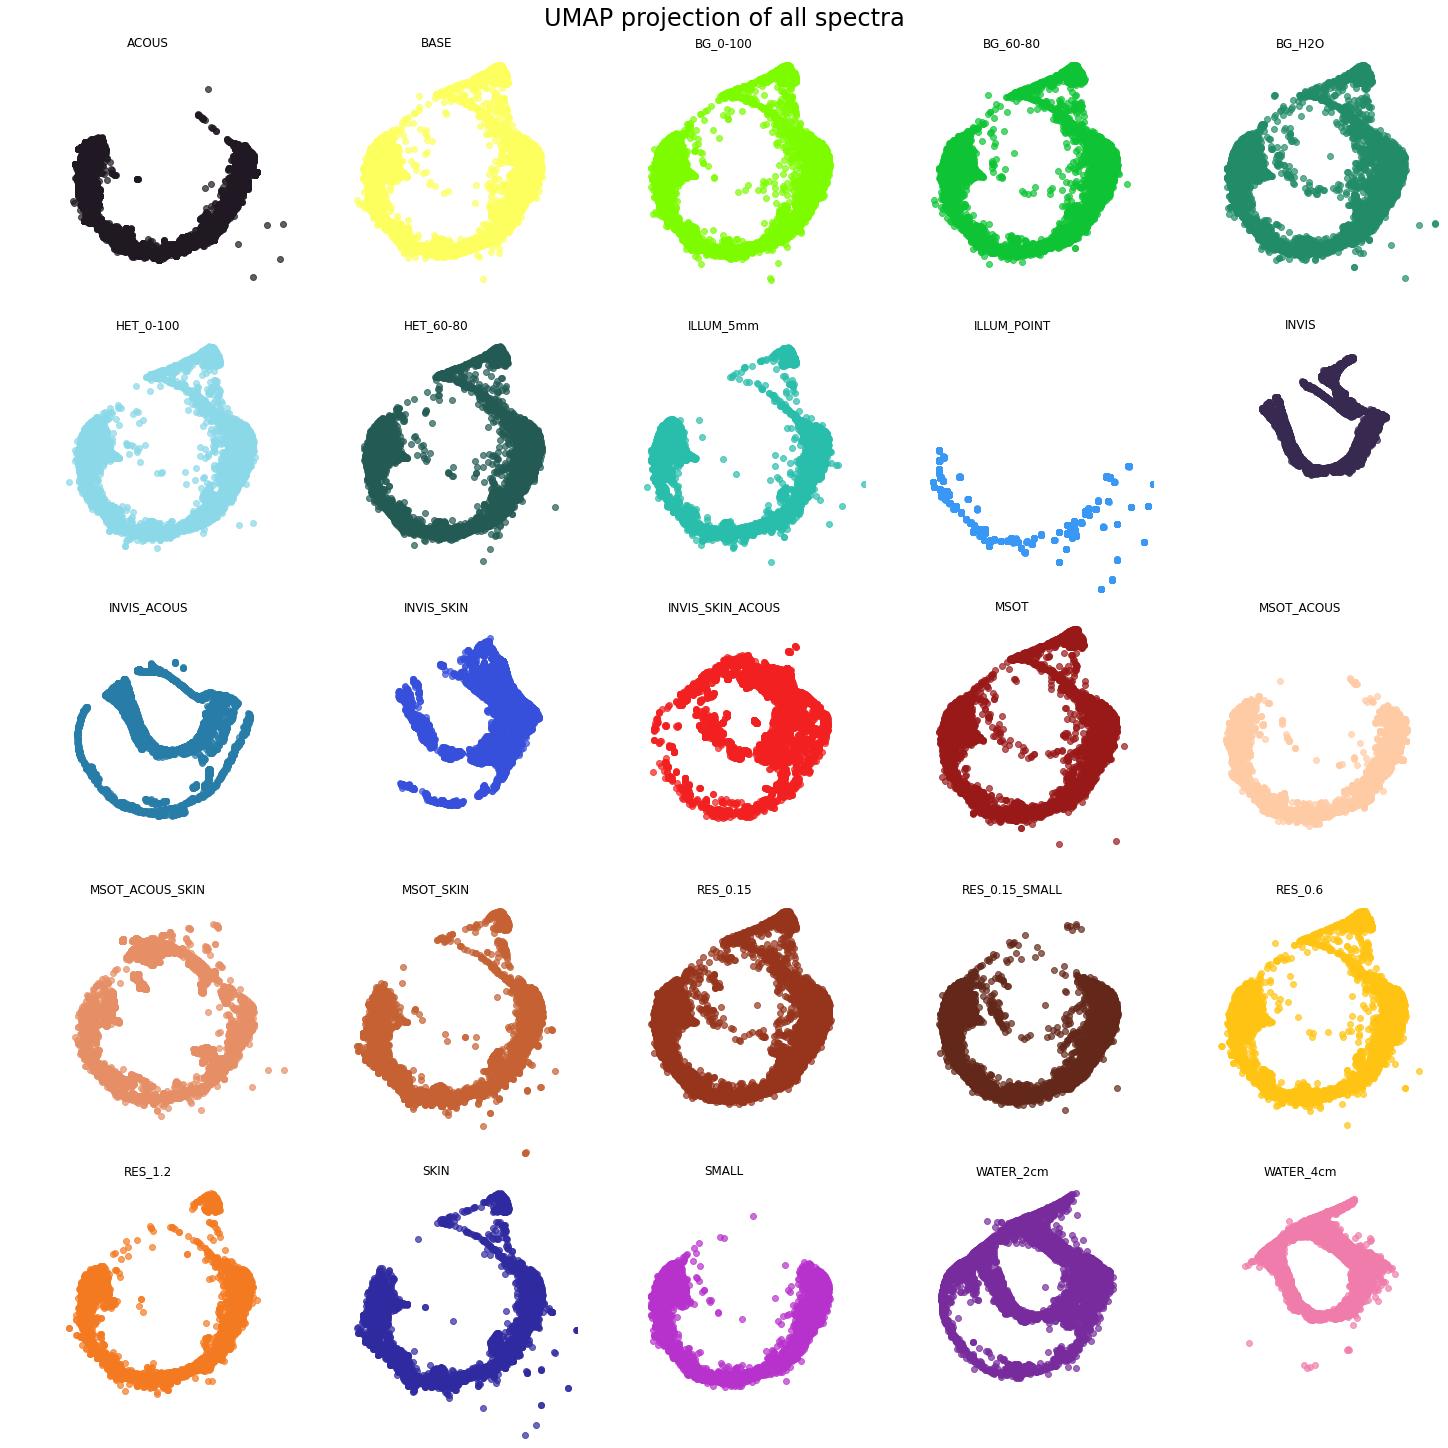

In [62]:
N_POINTS = 10000
n_datasets = len(np.unique(all_ds_idx))
plt.figure(figsize=(20, 20), layout="constrained")
plt.suptitle('UMAP projection of all spectra', fontsize=24)
for index in range(n_datasets):
    plt.subplot(5, 5, index + 1)
    plt.title(datasets[index])
    plt.scatter(
        embedding[all_ds_idx[random_idx]==index, 0][:N_POINTS],
        embedding[all_ds_idx[random_idx]==index, 1][:N_POINTS],
        c=COLOURS[index],
        alpha=0.7)
    plt.ylim(-10, 15)
    plt.xlim(-15, 20)
    plt.axis("off")
plt.show()
plt.close()